In [40]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, models

In [41]:
# Set ggplot styles and update Matplotlib with them.
ggplot_styles = {
    'axes.edgecolor': 'white',
    'axes.facecolor': 'EBEBEB',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': 'white',
    'grid.linewidth': '1.2',
    'xtick.color': 'black',
    'xtick.major.bottom': True,
    'xtick.minor.bottom': False,
    'ytick.color': 'black',
    'ytick.major.left': True,
    'ytick.minor.left': False,
}

plt.rcParams.update(ggplot_styles)

In [42]:
#PARAMETERS
BASE_PATH = ".."
DATA_PATH = os.path.join(BASE_PATH, "data", "trait_descriptors") #Path to trait descriptions
NUM_EMBEDDINGS = 25 #Number of embeddings to generate per trait description

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device loaded: {device}. There are {torch.cuda.device_count()} GPU(s) available.")

Device loaded: cuda. There are 1 GPU(s) available.


### Load finetuned model



In [ ]:
model = SentenceTransformer("imageomics/trait2vec")

### Load a non-finetuned model

In [45]:
word_embedding_model = models.Transformer("sentence-transformers/all-mpnet-base-v2",
                                          max_seq_length=256)

pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                                   pooling_mode_cls_token=True,
                                   pooling_mode_mean_tokens=False,
                                   pooling_mode_max_tokens=False,
                                   pooling_mode_weightedmean_tokens = False,
                                   pooling_mode_lasttoken = False)

dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(),
                           out_features=256,
                           activation_function=nn.Tanh())

pretrain_model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model])

### Load trait descriptors

In [46]:
with open(os.path.join(DATA_PATH, "fin.tsv"), 'r') as f:
  fin_descriptors = pd.read_csv(f, sep='\t')['?description'].to_list()[:NUM_EMBEDDINGS]

with open(os.path.join(DATA_PATH, "jaw.tsv"), 'r') as f:
  jaw_descriptors = pd.read_csv(f, sep='\t')['?description'].to_list()[:NUM_EMBEDDINGS]

### Project finetuned embeddings

In [47]:
fin_embeddings = model.encode(fin_descriptors)
jaw_embeddings = model.encode(jaw_descriptors)
Z_emb = np.concatenate([fin_embeddings, jaw_embeddings], axis=0)
y_emb = ['fin']*len(fin_embeddings) + ['jaw']*len(jaw_embeddings)

In [48]:
model_pca = PCA(n_components=2).fit(Z_emb)
expl_var = model_pca.explained_variance_ratio_

In [49]:
Z_pca = PCA(n_components=2).fit_transform(Z_emb)

### Project non-finetuned embeddings

In [50]:
pretrain_fin_embeddings = pretrain_model.encode(fin_descriptors)
pretrain_jaw_embeddings = pretrain_model.encode(jaw_descriptors)
pretrain_Z_emb = np.concatenate([pretrain_fin_embeddings, pretrain_jaw_embeddings], axis=0)

In [51]:
pretrain_Z_pca = PCA(n_components=2).fit_transform(pretrain_Z_emb)

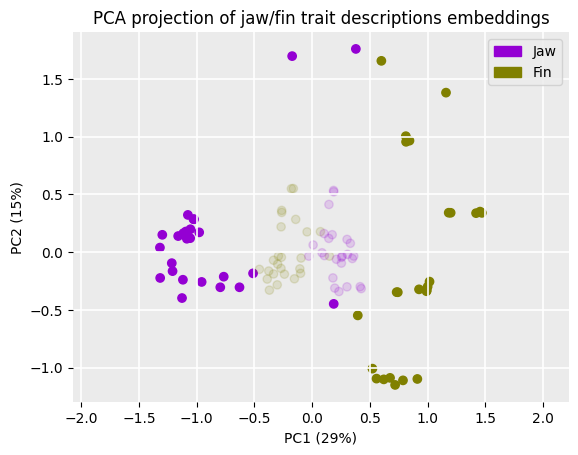

In [52]:
#PLOT EMBEDDINGS
lbl_to_color = {"jaw":'darkviolet', "fin":'olive'}
plt.scatter(
  Z_pca[:, 0],
  Z_pca[:, 1],
  c=[lbl_to_color[x] for x in y_emb])
plt.scatter(
  pretrain_Z_pca[:, 0],
  pretrain_Z_pca[:, 1],
  c=[lbl_to_color[x] for x in y_emb], alpha=.15)
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'PCA projection of jaw/fin trait descriptions embeddings', c='black')
plt.xlabel(f'PC1 ({expl_var[0]*100:.0f}%)')
plt.ylabel(f'PC2 ({expl_var[1]*100:.0f}%)')
plt.legend(handles=[mpatches.Patch(color=lbl_to_color[k], label=k.capitalize()) for k in lbl_to_color.keys()])

### Closest PCA-projected of finetuned embeddings.

In [53]:
dist_A = np.array([[np.linalg.norm(i-j)**2 for j in Z_pca] for i in Z_pca])

In [54]:
matrix = dist_A[:len(fin_embeddings), len(jaw_embeddings):] + np.tril(np.ones((NUM_EMBEDDINGS, NUM_EMBEDDINGS), dtype=int))*100

k = 2  # Number of smallest values to find

flattened_matrix = matrix.flatten()

partitioned_indices = np.argpartition(flattened_matrix, k)

smallest_value_indices_flat = partitioned_indices[:k]

row_indices, col_indices = np.unravel_index(smallest_value_indices_flat, matrix.shape)

k_smallest_indices = list(zip(row_indices, col_indices))

print(f"The k={k} matrix indices with the smallest values are: {k_smallest_indices}")

The k=2 matrix indices with the smallest values are: [(np.int64(11), np.int64(19)), (np.int64(2), np.int64(3))]


In [55]:
#Get closests embeddings in embedding space.
for x, y in k_smallest_indices:
  print('Fin:', fin_descriptors[x],'|', 'Jaw:', jaw_descriptors[y])

Fin: Stegural with anterodorsal membranous growth. Absence in Argentinoidei is secondary by parsimony optimization: Stegural with anterodorsal membranous growth | Jaw: Palatine: narrow comma-shaped palatine, lacking a posterior process
Fin: Fleshy lobe of paired fins: absent | Jaw: Fleshy flap anterolaterally on the lower jaw: absent


### Embedding quantiles of finetuned embeddings

In [56]:
emb_dist_A = np.array([[np.linalg.norm(i-j)**2 for j in Z_emb] for i in Z_emb])

In [57]:
rows = []
concat_descriptors = fin_descriptors + jaw_descriptors
for p in [0,.25, .5,.75, 1]:
  q = np.quantile(emb_dist_A[np.triu_indices(len(emb_dist_A), k=1)], p, method='higher')
  d = np.where(emb_dist_A == q)[0]
  t1_group = "Jaw"
  if d[0]<NUM_EMBEDDINGS:
    t1_group = "Fin"
  t2_group = "Jaw"
  if d[1]<NUM_EMBEDDINGS:
    t2_group = "Fin"
  rows += [{"Quantile":f"{p:.2f}", "Trait 1":f"({t1_group})"+concat_descriptors[d[0]], "Trait 2":f"({t2_group})"+concat_descriptors[d[1]]}]
  print(f"{p}|{concat_descriptors[d[0]]}|{concat_descriptors[d[1]]}")

0|Jaw teeth-shape and size gradation: scarcely curved, moderate anteroposterior gradation in size|Jaw teeth-shape and size gradation: strongly curved, moderate anteroposterior gradation in size
0.25|neural arch PU2: present|Form of retroarticular: retroarticular elongate and rod-shaped, with interopercular-mandibular ligament attaching at posterior margin of bone
0.5|(H5.) Pectoral attachment rotated; primitive \"metapterygial axis\" transverse or oblique to body axis: pectoral attachment rotated|Fleshy flap anterolaterally on the lower jaw: present
0.75|Paired fins, pelvic girdle and scapulocoracoids absent in adults: Paired fins, pelvic girdle and scapulocoracoids absent in adults|Palatine: narrow comma-shaped palatine, lacking a posterior process
1|Pectoral fin: rounded, horizontally placed, posteriormost tip reaching point midway between pectoral-fin origin and pelvic-fin origin when adpressed|Palatine: narrow comma-shaped palatine, lacking a posterior process


In [58]:
print(pd.DataFrame(rows).to_latex(index=False))

\begin{tabular}{lll}
\toprule
Quantile & Trait 1 & Trait 2 \\
\midrule
0.00 & (Jaw)Jaw teeth-shape and size gradation: scarcely curved, moderate anteroposterior gradation in size & (Jaw)Jaw teeth-shape and size gradation: strongly curved, moderate anteroposterior gradation in size \\
0.25 & (Fin)neural arch PU2: present & (Jaw)Form of retroarticular: retroarticular elongate and rod-shaped, with interopercular-mandibular ligament attaching at posterior margin of bone \\
0.50 & (Fin)(H5.) Pectoral attachment rotated; primitive \"metapterygial axis\" transverse or oblique to body axis: pectoral attachment rotated & (Jaw)Fleshy flap anterolaterally on the lower jaw: present \\
0.75 & (Fin)Paired fins, pelvic girdle and scapulocoracoids absent in adults: Paired fins, pelvic girdle and scapulocoracoids absent in adults & (Jaw)Palatine: narrow comma-shaped palatine, lacking a posterior process \\
1.00 & (Fin)Pectoral fin: rounded, horizontally placed, posteriormost tip reaching point midway b

### Embedding quantiles of non-finetuned embeddings

In [59]:
emb_dist_A = np.array([[np.linalg.norm(i-j)**2 for j in pretrain_Z_emb] for i in pretrain_Z_emb])

In [60]:
rows = []
concat_descriptors = fin_descriptors + jaw_descriptors
for p in [0,.25, .5,.75, 1]:
  q = np.quantile(emb_dist_A[np.triu_indices(len(emb_dist_A), k=1)], p, method='higher')
  d = np.where(emb_dist_A == q)[0]
  t1_group = "Jaw"
  if d[0]<NUM_EMBEDDINGS:
    t1_group = "Fin"
  t2_group = "Jaw"
  if d[1]<NUM_EMBEDDINGS:
    t2_group = "Fin"
  rows += [{"Quantile":f"{p:.2f}", "Trait 1":f"({t1_group})"+concat_descriptors[d[0]], "Trait 2":f"({t2_group})"+concat_descriptors[d[1]]}]
  print(f"{p}|{concat_descriptors[d[0]]}|{concat_descriptors[d[1]]}")

0|Form of retroarticular: retroarticular elongate and cup-shaped, with its length in lateral view more than three times its height, with interopercularmandibular ligament attaching in cup-shaped depression near anterior margin of bone|Form of retroarticular: retroarticular elongate and cup-shaped, with its length in lateral view more than three times its height, with interopercular-mandibular ligament attaching in cup-shaped depression near anterior margin of bone
0.25|Jaw teeth-shape and size gradation: strongly curved, moderate anteroposterior gradation in size|Autopalatine: ossification well developed in M. barbata, its length nearly equal to the width of the anterior cartilage head of autopalatine
0.5|Shape of teeth: teeth in both jaws conical, with a broad base tapering toward the cusp|Form of retroarticular: retroarticular elongate and cup-shaped, with its length in lateral view more than three times its height, with interopercular-mandibular ligament attaching in cup-shaped depr

In [61]:
print(pd.DataFrame(rows).to_latex(index=False))

\begin{tabular}{lll}
\toprule
Quantile & Trait 1 & Trait 2 \\
\midrule
0.00 & (Jaw)Form of retroarticular: retroarticular elongate and cup-shaped, with its length in lateral view more than three times its height, with interopercularmandibular ligament attaching in cup-shaped depression near anterior margin of bone & (Jaw)Form of retroarticular: retroarticular elongate and cup-shaped, with its length in lateral view more than three times its height, with interopercular-mandibular ligament attaching in cup-shaped depression near anterior margin of bone \\
0.25 & (Jaw)Jaw teeth-shape and size gradation: strongly curved, moderate anteroposterior gradation in size & (Jaw)Autopalatine: ossification well developed in M. barbata, its length nearly equal to the width of the anterior cartilage head of autopalatine \\
0.50 & (Jaw)Shape of teeth: teeth in both jaws conical, with a broad base tapering toward the cusp & (Jaw)Form of retroarticular: retroarticular elongate and cup-shaped, with its le